In [1]:
import sys
import os
sys.path.append("../..")
from diachr import DiachromaticInteractionSet
from diachr import ReadTypeAndConfigCounter

# Create directory for output files generated in this notebook 
NOTEBOOK_RESULTS_DIR = 'read_type_and_configuration_frequencies_results'
%mkdir -p $NOTEBOOK_RESULTS_DIR

# Read type and configuration frequencies

In this notebook, we determine the frequencies of the four types of mapped paired-end reads and the ten configurations across interactions of an interaction file generated with `DICer.py`, i.e., the interactions have already been classified as unbalanced or balanced. In order to keep the layout clear we have outsourced functions functions for counting and plotting to a separate module.

In [2]:
rtac_Counter = ReadTypeAndConfigCounter()

## Loading interaction data

We generated interaction files for Hi-C and cpature Hi-C data on the 17 hematopoietic cell types using `DICer` and placed them in a directory named `diachrscripts/DICer_interactions`.

### Download interaction file for Mifsud data

 In addition, we provide a corresponding interaction file for download, which we have prepared for capture Hi-C data from the publication by [Mifsud et al. (2015)](https://pubmed.ncbi.nlm.nih.gov/25938943/).

In [3]:
!mkdir -p ../../DICer_interactions/CHC
!wget -O ../../DICer_interactions/CHC/MIF_GM12878_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz https://www.genecascade.org/downloads/diachrscripts/MIF_REPC_evaluated_and_categorized_interactions.tsv.gz

--2022-10-07 07:14:43--  https://www.genecascade.org/downloads/diachrscripts/MIF_REPC_evaluated_and_categorized_interactions.tsv.gz
Resolving www.genecascade.org (www.genecascade.org)... 193.175.174.14
Connecting to www.genecascade.org (www.genecascade.org)|193.175.174.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70203503 (67M) [application/x-gzip]
Saving to: ‘../../DICer_interactions/CHC/MIF_GM12878_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz’

../../DICer_interac 100%[===================>]  66.95M  6.96MB/s    in 9.8s    

2022-10-07 07:14:53 (6.83 MB/s) - ‘../../DICer_interactions/CHC/MIF_GM12878_CHC_REPC_evaluated_and_categorized_interactions.tsv.gz’ saved [70203503/70203503]



### Choose a file

In [7]:
AUTHOR = 'JAV' # MIF or JAV
PROTOCOL = 'CHC' # HC or CHC
CELL_TYPE_SHORT = 'MAC_M0' # GM12878, MK, ERY, NEU, MON, MAC_M0, ...
OUT_PREFIX = AUTHOR + '_' + CELL_TYPE_SHORT + '_' + PROTOCOL +'_REPC'
INTERACTION_FILE = '../../DICer_interactions/' + PROTOCOL + '/' + OUT_PREFIX + '_evaluated_and_categorized_interactions.tsv.gz' 

In [3]:
INTERACTION_FILE = '../../jupyter_notebooks/usage/HC/DEMO_1_evaluated_and_categorized_interactions.tsv.gz'
OUT_PREFIX = 'HC_test'

### Read interactions into data structure

In [4]:
# Create DiachromaticInteractionSet
d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(
    i_file = INTERACTION_FILE,
    verbose = True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../../jupyter_notebooks/usage/HC/DEMO_1_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Set size: 46,161
[INFO] ... done.


## Frequencies of the for types of mapped paired-end reads

In paired-end sequencing, four types read pairs can be distinguished after mapping:

1. The reads are mapped onto different strands and point to each other (Type `0`)
2. The reads are mapped onto different strands and point away from each other (Type `1`)
3. The reads both are mapped to the forward strand (Type `2`)
4. The reads both are mapped to the reverse strand (Type `3`)

Here we determine the frequencies of the four types across all interactions as well as across all unbalanced and balanced interactions.

### Count reads separately by type

In [5]:
RP_TYPE_FREQ_DICT, RP_TYPE_DENS_DICT = rtac_Counter.count_read_types(d11_interaction_set)

### Output frequencies as a table

In [6]:
rtac_Counter.print_read_type_frequency_tables(
    rp_type_freq_dict = RP_TYPE_FREQ_DICT,
    rp_type_dens_dict = RP_TYPE_DENS_DICT,
    i_cats = ['U','B','ALL'],
    print_dens=True)

U
		T0	T1	T2	T3
	NN: 	0.30	0.20	0.21	0.28
	EE: 	0.36	0.17	0.17	0.30
	NE: 	0.35	0.12	0.17	0.35
	EN: 	0.31	0.21	0.25	0.23
	ALL: 	0.31	0.19	0.21	0.29

B
		T0	T1	T2	T3
	NN: 	0.26	0.24	0.23	0.27
	EE: 	0.29	0.22	0.23	0.26
	NE: 	0.27	0.23	0.22	0.28
	EN: 	0.27	0.23	0.24	0.26
	ALL: 	0.27	0.24	0.23	0.27

ALL
		T0	T1	T2	T3
	NN: 	0.26	0.24	0.23	0.27
	EE: 	0.30	0.22	0.22	0.26
	NE: 	0.28	0.23	0.22	0.28
	EN: 	0.27	0.23	0.24	0.26
	ALL: 	0.27	0.24	0.23	0.27



### Output frequencies as a bar chart

Use `NN`, `NE`, `EN` or `EE` to plot the frequencies of specific enrichment categories. Use `ALL` to plot the frequencies across all enrichment categories.

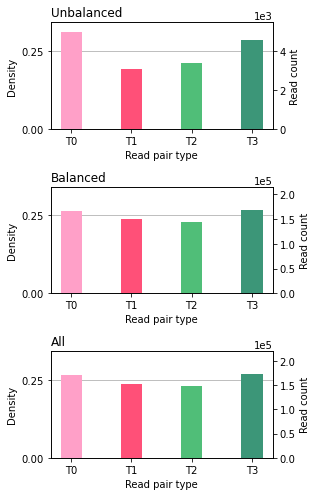

In [7]:
fig = rtac_Counter.create_read_type_frequency_bar_charts(
    rp_type_freq_dict = RP_TYPE_FREQ_DICT,
    rp_type_dens_dict = RP_TYPE_DENS_DICT,
    i_cats = ['U','B','ALL'],
    e_cat = 'ALL',
    pdf_file_name = NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX + '_rp_type_frequency_bar_charts.pdf')

## Frequencies of configurations

We distinguish ten configurations of interactions (`0X`, `1X`, `2X`, `3X`, `01`, `02`, `03`, `12`, `13`, `23`), depending on which of the four types of mapped paired-end reads predominate within individual interactions.

### Count interactions separately by configuration

In [8]:
CONF_FREQ_DICT, CONF_DENS_DICT = rtac_Counter.count_configurations(d11_interaction_set)

### Output frequencies as a table

In [9]:
rtac_Counter.print_configuration_frequency_tables(
    conf_freq_dict = CONF_FREQ_DICT,
    conf_dens_dict = CONF_DENS_DICT,
    i_cats = ['U', 'B', 'ALL'])

U
		NN		EE		NE		EN		ALL
	0X: 	29 (0.03)	1 (0.07)	3 (0.03)	4 (0.05)	37 (0.04)
	1X: 	16 (0.02)	1 (0.07)	1 (0.01)	4 (0.05)	22 (0.02)
	2X: 	13 (0.02)	0 (0.00)	1 (0.01)	4 (0.05)	18 (0.02)
	3X: 	22 (0.03)	0 (0.00)	6 (0.07)	0 (0.00)	28 (0.03)
	01: 	4 (0.00)	0 (0.00)	1 (0.01)	1 (0.01)	6 (0.01)
	02: 	186 (0.22)	3 (0.20)	19 (0.21)	26 (0.31)	234 (0.23)
	03: 	259 (0.31)	6 (0.40)	44 (0.48)	21 (0.25)	330 (0.32)
	12: 	138 (0.17)	3 (0.20)	8 (0.09)	10 (0.12)	159 (0.16)
	13: 	154 (0.19)	1 (0.07)	9 (0.10)	15 (0.18)	179 (0.18)
	23: 	8 (0.01)	0 (0.00)	0 (0.00)	0 (0.00)	8 (0.01)
B
		NN		EE		NE		EN		ALL
	0X: 	41 (0.00)	0 (0.00)	4 (0.00)	5 (0.00)	50 (0.00)
	1X: 	9 (0.00)	0 (0.00)	1 (0.00)	2 (0.00)	12 (0.00)
	2X: 	18 (0.00)	0 (0.00)	1 (0.00)	0 (0.00)	19 (0.00)
	3X: 	22 (0.00)	0 (0.00)	5 (0.00)	4 (0.00)	31 (0.00)
	01: 	7,105 (0.18)	36 (0.14)	377 (0.16)	370 (0.15)	7,888 (0.17)
	02: 	7,999 (0.20)	55 (0.22)	454 (0.19)	571 (0.24)	9,079 (0.20)
	03: 	9,508 (0.24)	79 (0.32)	654 (0.27)	541 (0.23)	10,782 (0.24)
	12: 	5,

### Output frequencies as a bar chart

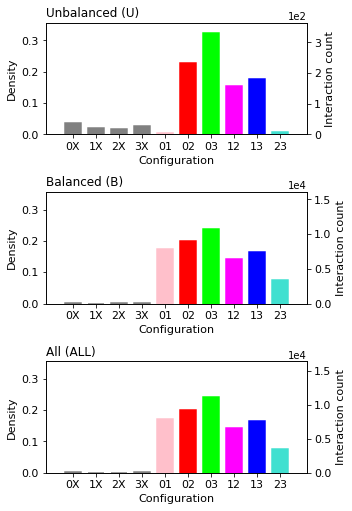

In [10]:
# Use this method for Hi-C datasets
fig = rtac_Counter.create_configuration_frequency_bar_charts(
    i_cats = ['U', 'B', 'ALL'],
    conf_freq_dict = CONF_FREQ_DICT,
    e_cat_1 = 'ALL',
    pdf_file_name = NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX + '_configuration_frequency_bar_charts.pdf'
    )

### Output frequencies as a bar chart with two bars for each configuration

For capture Hi-C data, we can distinguish interactions by enrichment states, i.e., whether interaction go from the baited digest towards 5' (`NE`) or 3' (`EN`) direction.

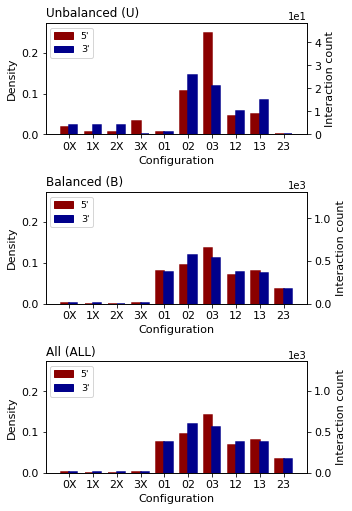

In [11]:
# Use this for CHC data
fig = rtac_Counter.create_configuration_frequency_bar_charts_2(
    conf_freq_dict = CONF_FREQ_DICT,
    i_cats = ['U', 'B', 'ALL'],
    e_cat_1 = 'NE',
    e_cat_2 = 'EN',
    e_cat_1_color = 'darkred',
    e_cat_2_color = 'darkblue',
    pdf_file_name = NOTEBOOK_RESULTS_DIR + '/' + OUT_PREFIX + '_configuration_frequency_bar_charts_2.pdf'
    )